In [1]:
import sys
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def show_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

def show_image_gray(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

# funciton from ROS node

In [3]:
def detect_circles(image: np.ndarray)->np.ndarray:
    """
    Image is assumned to come as BGR (for now)
    """
    rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
    # Reduce the noise to avoid false circle detection
    gray = cv.medianBlur(gray, 5)

    rows = gray.shape[0]
    circles = cv.HoughCircles(image=gray, method=cv.HOUGH_GRADIENT,dp= 1,
                                minDist= rows / 8,
                                param1=100, param2=30,
                                minRadius=1, maxRadius=int(0.8*rows)
                                )
    
    return np.array([]) if circles is None else circles

def paint_circles_in_image(image: np.ndarray, circles: np.ndarray, n:int=1)->np.ndarray:
    """
    paints the fist n circles from 'circles' in the image
    """
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i, circle_i in enumerate(circles[0, :], start=1):
            if i > n:
                break
            center = (circle_i[0], circle_i[1])
            radius = circle_i[2]

            cv.circle(image, center, 1, (0, 100, 100), 3)
            cv.circle(image, center, radius, (255, 0, 255), 3)
            # write index next to circle center
            cv.putText(image, str(i), (circle_i[0], circle_i[1]), cv.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 255), 5)

    return image

def find_circles_in_image(image: np.ndarray, n:int=3)->np.ndarray:
    """
    Detects circles in the image and paints the first n circles in the image
    image: np.ndarray: image to detect circles in
    n: int: number of circles to paint in the image
    """
    circles = detect_circles(image)
    return circles, paint_circles_in_image(image, circles, n=n)


# visual functions

In [4]:
def paint_centerlines_in_image(image: np.ndarray)->np.ndarray:
    """
    Paints a horizontal and vertical line in the center of the image
    ---
    image: np.ndarray: image to paint the lines in
    """
    rows, cols = image.shape[:2]
    cv.line(image, (0, rows // 2), (cols, rows // 2), (0, 255, 0), 3)
    cv.line(image, (cols // 2, 0), (cols // 2, rows), (0, 255, 0), 3)
    return image

def paint_x_in_image(image: np.ndarray, x:int, y:int, x_line_length:int=10)->np.ndarray:
    """
    Paints a cross in the image at the given coordinates
    ---
    image: np.ndarray: image to paint the cross in
    x: int: x coordinate of the cross
    y: int: y coordinate of the cross
    """
    red_color = (0, 0, 255)
    blue_color = (255, 0, 0)
    cv.line(image, (x - x_line_length, y), (x + x_line_length, y), red_color, 10)
    cv.line(image, (x, y - x_line_length), (x, y + x_line_length), red_color, 10)
    return image

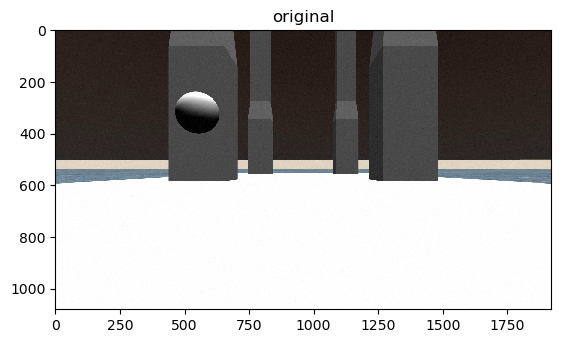

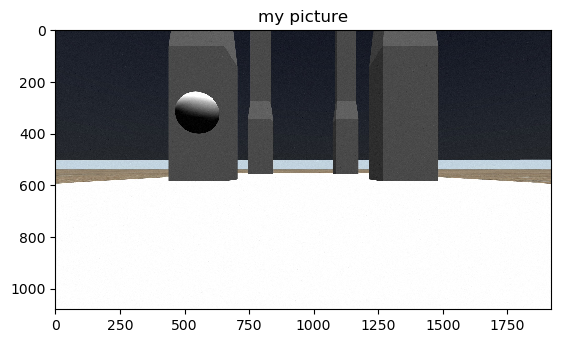

In [5]:
filename = '5.jpg'
bgr = og_img = cv.imread(filename)
show_image(og_img, 'original')

rgb = cv.cvtColor(og_img, cv.COLOR_BGR2RGB)
show_image(rgb, 'my picture')

gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
# Reduce the noise to avoid false circle detection
gray = cv.medianBlur(gray, 5)
# show_image_gray(gray, 'gray picture')


circles detected: (1, 1, 3)


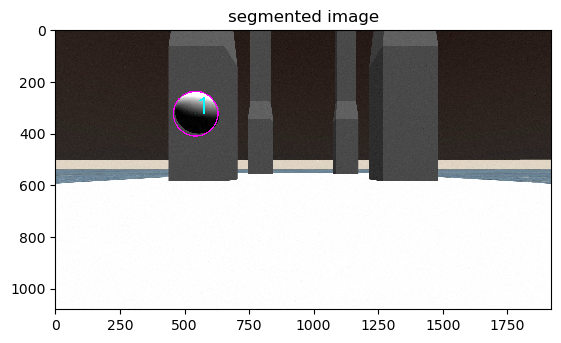

In [6]:
circles, segmented_img = find_circles_in_image(bgr) # TODO: take this functions to another module. Problem with setup.py
print(f"circles detected: {circles.shape}")
show_image(segmented_img, 'segmented image')

In [13]:
def img_error(target_center: tuple, img_dims:tuple)->np.ndarray:
    """
    Calculates the error of the circle center in the image
    ---
    target_center: (u,v) tuple: center of the target circle in image space
    img_dims: (rows, cols) tuple: dimensions of the image
    """
    assert len(target_center) == 2, "target_center must be a tuple with 2 elements"
    assert len(img_dims) == 2, "img_dims must be a tuple with 2 elements"

    center_x, center_y = target_center
    u, v = int(center_x), int(center_y) # u,v to pixel indices, not great
    error_h = np.abs(u - img_dims[0] // 2)
    error_v = np.abs(v - img_dims[1] // 2)
    return error_h, error_v

def paint_img_errors(img: np.ndarray, target_center: tuple)->np.ndarray:
    error_h, error_v = img_error(target_center, img.shape[:2])

    cv.putText(img, f"error_h: {error_h}", (10, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    cv.putText(img, f"error_v: {error_v}", (10, 100), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

    x,y = target_center[:2]
    cv.line(img, (x, y), (img.shape[1] // 2, y), (255, 0, 0), 10)
    cv.line(img, (x, y), (x, img.shape[0] // 2), (255, 0, 0), 10)
    return img

error_h: 4, error_v: 634


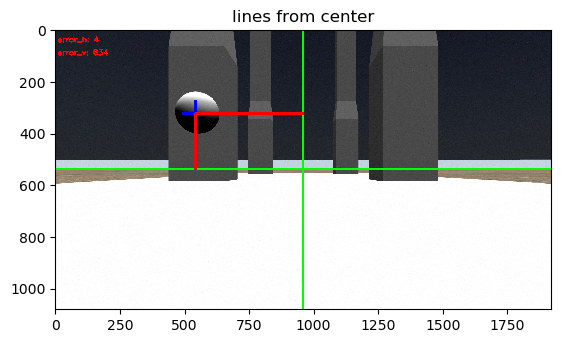

In [17]:
img = rgb.copy()
img_dims = img.shape[:2]
circle_1 = circles[0,0]
center_x, center_y, radius = circle_1
center_u, center_v = int(center_x), int(center_y) # u,v to pixel indices, not great

img_w_x = paint_x_in_image(img, center_u, center_v, 50)
_img = img_w_x.copy()
img_w_centerlines = paint_centerlines_in_image(_img)

# show_image(img_w_x, 'center lines')
# show_image(img_w_centerlines, 'center lines')

error_h, error_v = img_error((center_u, center_v), img_dims)

print(f"error_h: {error_h}, error_v: {error_v}")

# paint lines from circle center to each center line
img_w_lines_n_error = img_w_centerlines.copy()
paint_img_errors(img_w_lines_n_error, (center_u, center_v))

show_image(img_w_lines_n_error, 'lines from center')
